In [1]:
%matplotlib inline
import torch as tc
import tensorflow as tf
import mxnet as mx
from mxnet import np as mxnp
from mxnet import npx as npx
npx.set_np()
# import numpy as np

from d2l import mxnet as mxd2l  # Use MXNet as the backend
from d2l import torch as tcd2l  # Use PyTorch as the backend
from d2l import tensorflow as tfd2l  # Use TensorFlow as the backend

tc.__version__,tf.__version__,mx.__version__

('1.6.0', '2.3.1', '1.7.0')

## mxnet

In [2]:
from mxnet import autograd,gluon,init

In [3]:
net_mx=gluon.nn.Sequential()
net_mx.add(
    gluon.nn.Conv2D(channels=6,kernel_size=5,padding=2,activation='relu'),
    gluon.nn.MaxPool2D(pool_size=2,strides=2),
    gluon.nn.Conv2D(channels=16,kernel_size=5,activation='relu'),
    gluon.nn.MaxPool2D(pool_size=2,strides=2),
    gluon.nn.Flatten(),
    gluon.nn.Dense(120,activation='relu'),
    gluon.nn.Dense(84,activation='relu'),
    gluon.nn.Dense(10)
)
net_mx.initialize()

In [4]:
X = mxnp.random.uniform(size=(1, 1, 28, 28))
y=net_mx(X)
y.shape

(1, 10)

In [5]:
for layer in net_mx:
    X=layer(X)
    print(f"layer {layer.name},out shape={X.shape}")

layer conv0,out shape=(1, 6, 28, 28)
layer pool0,out shape=(1, 6, 14, 14)
layer conv1,out shape=(1, 16, 10, 10)
layer pool1,out shape=(1, 16, 5, 5)
layer flatten0,out shape=(1, 400)
layer dense0,out shape=(1, 120)
layer dense1,out shape=(1, 84)
layer dense2,out shape=(1, 10)


In [6]:
batch_size=512
lr=0.15
num_epochs=10
train_iter, test_iter = mxd2l.load_data_fashion_mnist(batch_size=batch_size)

loss 0.346, train acc 0.872, test acc 0.864
54188.9 examples/sec on gpu(0)


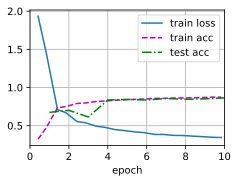

In [7]:
mxd2l.train_ch6(net_mx,train_iter,test_iter,num_epochs,lr)

## torch

In [130]:
class Reshape(tc.nn.Module):
    def forward(self ,x ):
        if len(x.shape)==2:
            return x.view((-1,1)+x.shape)
        else:
            return x

In [131]:
x=tc.randn(2,1,2,2)
x

tensor([[[[-0.3203,  0.1491],
          [ 0.9495,  0.5936]]],


        [[[-1.9629,  0.6868],
          [ 1.5014, -1.8295]]]])

In [132]:
reshapenet=Reshape()
y=reshapenet(x)
y.shape

torch.Size([2, 1, 2, 2])

In [133]:
net_tc=tc.nn.Sequential(
    Reshape(),
    tc.nn.Conv2d(1,6,kernel_size=5,padding=2),
    tc.nn.ReLU(),
    tc.nn.MaxPool2d(kernel_size=2,stride=2),
    tc.nn.Conv2d(6,16,kernel_size=5),
    tc.nn.ReLU(),
    tc.nn.MaxPool2d(kernel_size=2,stride=2),
    tc.nn.Flatten(),
    tc.nn.Linear(16*5*5,120),
    tc.nn.ReLU(),
    tc.nn.Linear(120,84),
    tc.nn.ReLU(),
    tc.nn.Linear(84,10)
)

In [134]:
def count_params(model):
    # Find total parameters and trainable parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} training parameters.')

In [135]:
count_params(net_tc)

61,706 total parameters.
61,706 training parameters.


In [136]:
def count_layers_params(model,X=None,verbose=False):
    # Find total parameters and trainable parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} training parameters.\n')
    
    i=0
    for layer in model:    
        name=layer if verbose else layer.__class__.__name__
        print(f"--Layer {i} :{name},  Params:{sum(p.numel() for p in layer.parameters())},  Trainable Params:{sum(p.numel() for p in layer.parameters() if p.requires_grad)}")
        if X is not None:
            X = layer(X)
            print('  ----output shape:',X.shape)
        i+=1
        print('\n')

In [138]:
# count_layers_params(net_tc,verbose=False)

In [139]:
# count_layers_params(net_tc,verbose=True)

In [140]:
# X = tc.randn(size=(2,1,28, 28), dtype=tc.float32)
# count_layers_params(net_tc,X=X,verbose=True)

In [126]:
batch_size = 512
train_iter, test_iter = tcd2l.load_data_fashion_mnist(batch_size=batch_size)

loss 0.321, train acc 0.880, test acc 0.875
88844.9 examples/sec on cuda:0


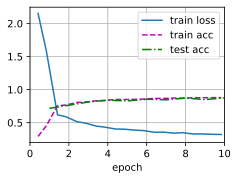

In [141]:
lr, num_epochs = 0.2, 10
tcd2l.train_ch6(net_tc, train_iter, test_iter, num_epochs, lr)

In [143]:
net_tc.device

ModuleAttributeError: 'Sequential' object has no attribute 'device'

In [145]:
next(iter(net_tc.parameters()))

Parameter containing:
tensor([[[[ 0.1076,  0.0940, -0.0136, -0.0104, -0.0712],
          [-0.1441, -0.2310, -0.0552, -0.2311, -0.0291],
          [ 0.0326, -0.0185, -0.1684, -0.1412, -0.1388],
          [ 0.0637, -0.0147, -0.2255,  0.0808,  0.0254],
          [-0.2233,  0.1068, -0.0995, -0.2312,  0.0274]]],


        [[[-0.6492, -0.6778, -0.4275, -0.0873,  0.0356],
          [-0.7213, -0.9332, -0.9008, -0.4177,  0.1798],
          [-0.1896, -0.5683, -0.7613, -0.3953,  0.5595],
          [ 0.2493, -0.5099, -0.2700, -0.0822,  0.2211],
          [ 0.4866,  0.4445,  0.0239, -0.1626, -0.0708]]],


        [[[ 0.1003,  0.3202, -0.5972, -0.0362,  0.1511],
          [ 0.3379,  0.4651, -0.8201, -0.1386,  0.2300],
          [ 0.5720,  0.4388, -0.6797, -0.4893, -0.1373],
          [ 0.2114,  0.2560, -0.5203, -0.0544,  0.2833],
          [ 0.5430,  0.3552, -0.2760, -0.4505, -0.2193]]],


        [[[ 0.1814,  0.1762,  0.4865,  0.3127, -0.0024],
          [-0.1049,  0.0892,  0.2312,  0.4237,  0.4678

## tenorflow

In [233]:
import tensorflow as tf
from d2l import tensorflow as tfd2l
from tensorflow.distribute import MirroredStrategy,OneDeviceStrategy

In [234]:
def net_tf():
    net=tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6,kernel_size=5,activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2,strides=2),
        tf.keras.layers.Conv2D(filters=16,kernel_size=5,activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2,strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120,activation='relu'),
        tf.keras.layers.Dense(84,activation='relu'),
        tf.keras.layers.Dense(10)        
    ])
    
    return net

In [235]:
net=net_tf()

In [236]:
net.build(input_shape=(2, 28, 28, 1))
net.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (2, 28, 28, 6)            156       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (2, 14, 14, 6)            0         
_________________________________________________________________
conv2d_21 (Conv2D)           (2, 10, 10, 16)           2416      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (2, 5, 5, 16)             0         
_________________________________________________________________
flatten_10 (Flatten)         (2, 400)                  0         
_________________________________________________________________
dense_30 (Dense)             (2, 120)                  48120     
_________________________________________________________________
dense_31 (Dense)             (2, 84)                 

In [237]:
X = tf.random.uniform((2, 28, 28, 3))
for layer in net.layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2D output shape: 	 (2, 28, 28, 6)
MaxPooling2D output shape: 	 (2, 14, 14, 6)
Conv2D output shape: 	 (2, 10, 10, 16)
MaxPooling2D output shape: 	 (2, 5, 5, 16)
Flatten output shape: 	 (2, 400)
Dense output shape: 	 (2, 120)
Dense output shape: 	 (2, 84)
Dense output shape: 	 (2, 10)


In [238]:
batch_size = 512
train_iter, test_iter = tfd2l.load_data_fashion_mnist(batch_size=batch_size)

In [239]:
class TrainCallback(tf.keras.callbacks.Callback):
    def __init__(self,net,train_iter,test_iter,num_epochs,device_name=tfd2l.try_all_gpus()):
        self.timer=tfd2l.Timer()
        self.animator=tfd2l.Animator(xlabel='epochs',ylabel='metrics',xlim=[1,num_epochs],legend=['train loss', 'train acc', 'test acc'])
        self.net=net
        self.train_iter=train_iter
        self.test_iter=test_iter
        self.num_epochs=num_epochs
        self.device_name=device_name
    def on_epoch_begin(self,epoch,logs=None):
        self.timer.start()
    def on_epoch_end(self,epoch,logs):
        self.timer.stop()
        test_acc=self.net.evaluate(self.test_iter,verbose=0,return_dict=True)['accuracy']
        metrics=(logs['loss'],logs['accuracy'],test_acc)
        self.animator.add(epoch+1,metrics)
        if epoch == self.num_epochs - 1:
            batch_size = next(iter(self.train_iter))[0].shape[0]
            num_examples = batch_size * tf.data.experimental.cardinality(
                self.train_iter).numpy()
            print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, '
                  f'test acc {metrics[2]:.3f}')
            print(f'{num_examples / self.timer.avg():.1f} examples/sec on '
                  f'{str(self.device_name)}')
    

In [251]:
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr,
              device=tfd2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, test_iter, num_epochs,
                             device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=1, callbacks=[callback])
    return net

loss 0.335, train acc 0.878, test acc 0.861
104211.2 examples/sec on /GPU:0
118/118 [==============================] - 1s 8ms/step - loss: 0.3352 - accuracy: 0.8777


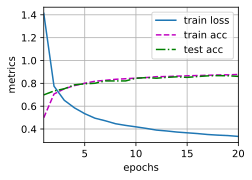

In [282]:
lr, num_epochs = 0.05, 20
train_ch6(net_tf, train_iter, test_iter, num_epochs, lr);

In [287]:
def net_tf_regularization():
    net=tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6,kernel_size=5,activation='relu',padding='same', kernel_regularizer='l2'),
        tf.keras.layers.MaxPooling2D(pool_size=2,strides=2),
        tf.keras.layers.Conv2D(filters=16,kernel_size=5,activation='relu', kernel_regularizer='l2'),
        tf.keras.layers.MaxPooling2D(pool_size=2,strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120,activation='relu', kernel_regularizer='l2'),
        tf.keras.layers.Dense(84,activation='relu', kernel_regularizer='l2'),
        tf.keras.layers.Dense(10, kernel_regularizer='l2')        
    ])
    
    return net
def train_ch6_re(net_fn,train_iter,test_iter,num_epochs,lr,device=tfd2l.try_all_gpus()):
    devices_names=[(d._device_name)+" " for d in device][0]
    strategy=MirroredStrategy()
    with strategy.scope():
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr)
        loss     =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net=net_fn()
        net.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
    callback=TrainCallback(net,train_iter,test_iter,num_epochs,devices_names)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net    

loss 0.134, train acc 0.949, test acc 0.896
111004.3 examples/sec on /GPU:0 


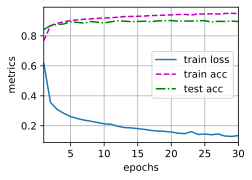

In [284]:
num_epochs=30
lr=0.01
train_ch6_re(net_tf, train_iter, test_iter, num_epochs, lr);

loss 0.119, train acc 0.956, test acc 0.895
121011.5 examples/sec on /GPU:0 


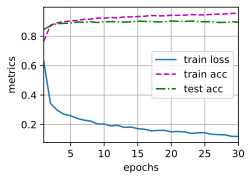

In [316]:
num_epochs=30
lr=0.01
train_ch6_re(net_tf, train_iter, test_iter, num_epochs, lr);

loss 0.750, train acc 0.843, test acc 0.842
116127.6 examples/sec on /GPU:0 


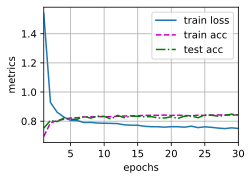

In [291]:
num_epochs=30
lr=0.006
train_ch6_re(net_tf_regularization, train_iter, test_iter, num_epochs, lr);

loss 0.214, train acc 0.927, test acc 0.909
114183.6 examples/sec on /GPU:0 


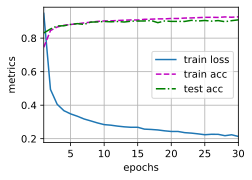

In [332]:
def net_tf_regularization():
    net=tf.keras.models.Sequential([
        #tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Conv2D(filters=6,kernel_size=5,activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2,strides=2),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv2D(filters=16,kernel_size=5,activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2,strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120,activation='relu'),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(84,activation='relu',kernel_regularizer='l2'),
        tf.keras.layers.Dense(10)        
    ])
    
    return net
def train_ch6_re(net_fn,train_iter,test_iter,num_epochs,lr,device=tfd2l.try_all_gpus()):
    devices_names=[(d._device_name)+" " for d in device][0]
    strategy=MirroredStrategy()
    with strategy.scope():
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr)        
        net=net_fn()
        loss     =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
    callback=TrainCallback(net,train_iter,test_iter,num_epochs,devices_names)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net  

num_epochs=30
lr=0.005
net=train_ch6_re(net_tf_regularization, train_iter, test_iter, num_epochs, lr);

In [306]:
#loss 0.134, train acc 0.949, test acc 0.896
#111004.3 examples/sec on /GPU:0

In [331]:
# net.predict(test_iter)

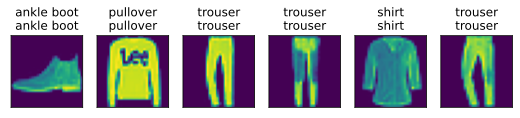

In [333]:
tfd2l.predict_ch3(net, test_iter)